In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import logging

FORMAT = '%(asctime)s %(message)s'

logging.basicConfig(level='INFO', format=FORMAT, datefmt='%d-%b-%y %H:%M:%S')

In [3]:
epoch_key = ("Jaq", 3, 12)

In [4]:
from dask.distributed import Client, TimeoutError, LocalCluster

client = Client(n_workers=32, threads_per_worker=1)
client

/home/edeno/miniconda3/envs/pose_analysis/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40311 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://127.0.0.1:43477 Dashboard: http://127.0.0.1:40311/status,Cluster Workers: 32 Cores: 32 Memory: 1.62 TB


In [5]:
from src.load_data import load_data

data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

16-Dec-20 14:14:14 Loading position info...
16-Dec-20 14:14:49 Loading multiunit...
16-Dec-20 14:15:13 Loading spikes...
16-Dec-20 14:16:40 Finding ripple times...


In [6]:
from replay_identification import ReplayDetector

detector_parameters = {
    'movement_var': 6.0,
    'replay_speed': 1,
    'place_bin_size': 2.0,
    'lfp_model_kwargs': {'n_components': 1, 'max_iter': 200, 'tol': 1e-06},
    'spike_model_knot_spacing': 10,
    'spike_model_penalty': 0.5,
    'movement_state_transition_type': 'random_walk',
    'speed_knots': [1., 2., 3., 40.],
}

replay_detector = ReplayDetector(**detector_parameters)
logging.info(replay_detector)

16-Dec-20 14:17:34 ReplayDetector(discrete_diagonal=None,
               discrete_state_transition_type='ripples_with_speed_threshold',
               infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               multiunit_density_mode...
               multiunit_model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.])},
               multiunit_occupancy_kwargs={'bandwidth': array([6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05,
               speed_knots=[1.0, 2.0, 3.0, 40.0], speed_threshold=4.0,
               spike_model_knot_s

In [7]:
EDGE_ORDER = [0, 1, 3, 2, 4]
EDGE_SPACING = [15, 0, 15, 0]

replay_detector.fit(
    is_ripple=data['is_ripple'],
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    track_graph=data['track_graph'],
    center_well_id=0,
    edge_order=EDGE_ORDER,
    edge_spacing=EDGE_SPACING,
)

16-Dec-20 14:17:34 Fitting speed model...
16-Dec-20 14:17:36 Fitting spiking model...


16-Dec-20 14:26:57 Fitting replay movement state transition...


16-Dec-20 14:26:58 Fitting replay state transition...


ReplayDetector(discrete_diagonal=None,
               discrete_state_transition_type='ripples_with_speed_threshold',
               infer_track_interior=True,
               lfp_model=<class 'sklearn.mixture._bayesian_mixture.BayesianGaussianMixture'>,
               lfp_model_kwargs={'max_iter': 200, 'n_components': 1,
                                 'tol': 1e-06},
               movement_state_transition_type='random_walk', movement_var=6.0,
               multiunit_density_mode...
               multiunit_model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.])},
               multiunit_occupancy_kwargs={'bandwidth': array([6.])},
               multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
               place_bin_size=2.0, position_range=None, replay_speed=1,
               replay_state_transition_penalty=1e-05,
               speed_knots=[1.0, 2.0, 3.0, 40.0], speed_threshold=4.0,
               spike_model_knot_spacing=10, spike_mo

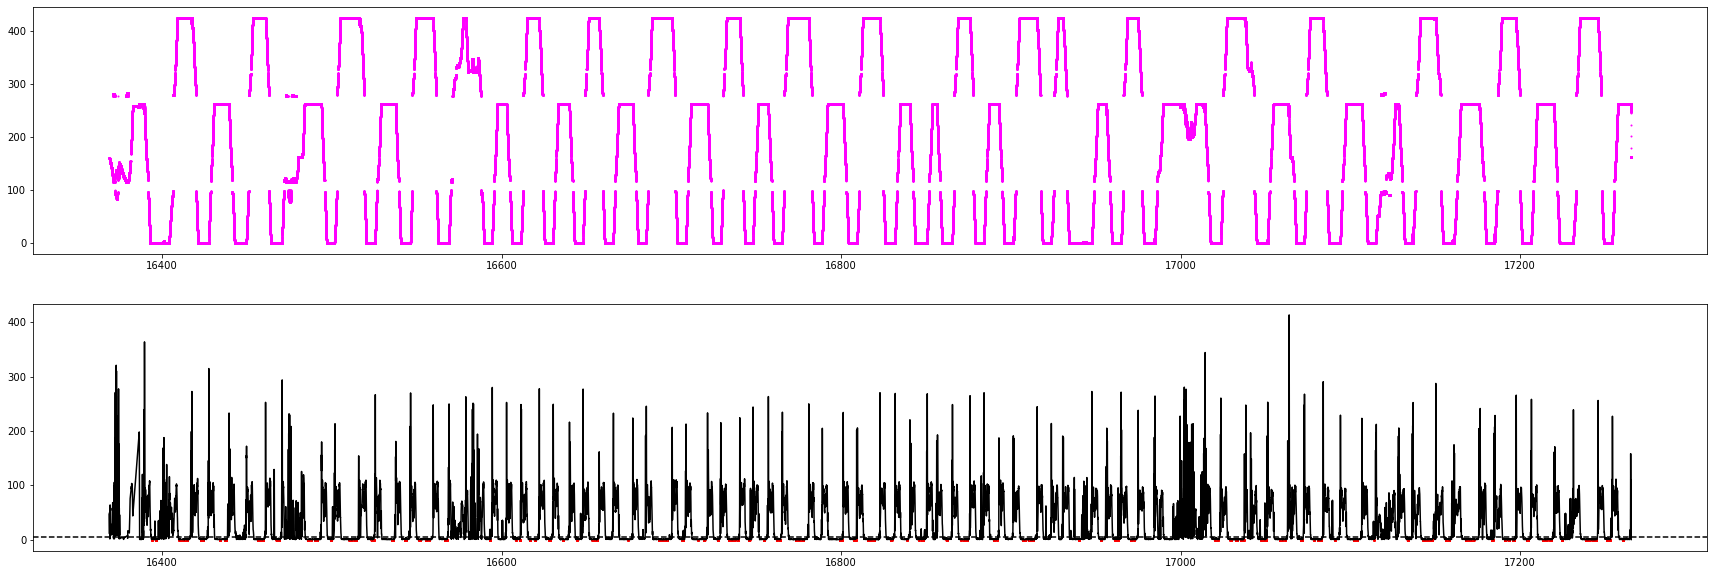

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(30, 10))
time = data['position_info'].index / np.timedelta64(1, 's')
axes[0].scatter(time, data['position_info'].linear_position, color='magenta', s=1)
axes[1].plot(time, data['position_info'].nose_vel, color='black')
ripple_ind = np.nonzero(data['is_ripple'].values.squeeze())[0]
axes[1].scatter(time[ripple_ind], np.zeros_like(time[ripple_ind]), color='red', s=1)
axes[1].axhline(4, color='black', linestyle='--')

distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


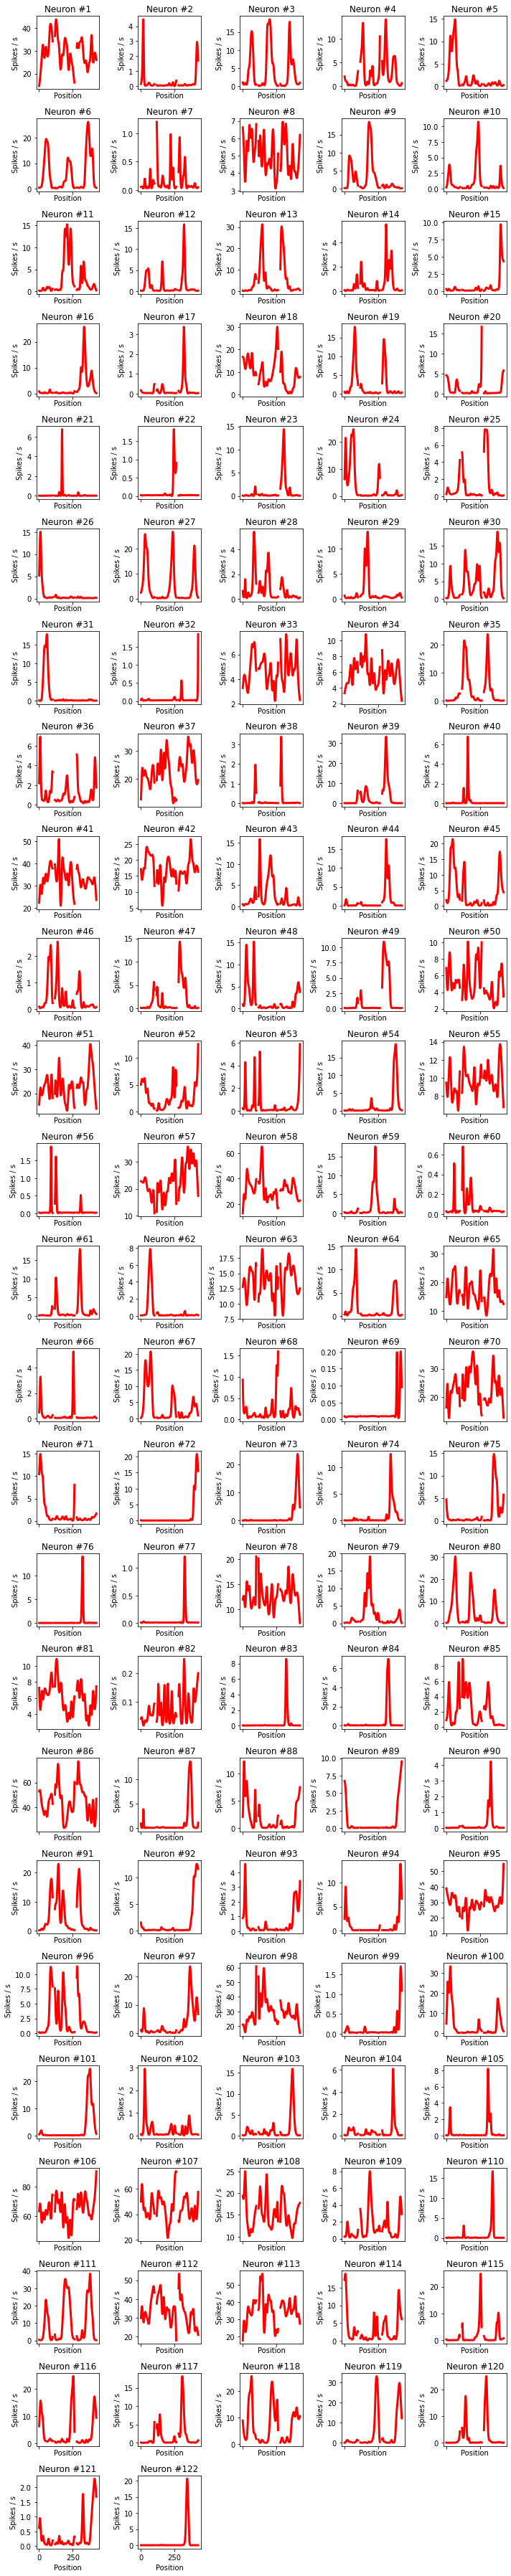

In [139]:
# replay_detector.plot_fitted_place_fields(sampling_frequency=500)

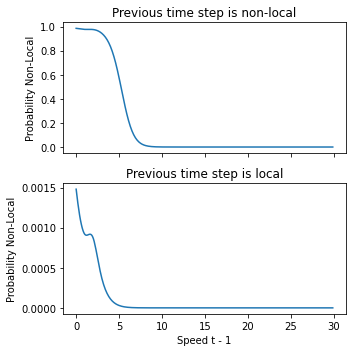

In [11]:
replay_detector.plot_replay_state_transition()

In [12]:
import numpy as np

detector_results = replay_detector.predict(
    speed=data['position_info'].nose_vel,
    position=data['position_info'].linear_position,
    spikes=data['spikes'],
    time=data['position_info'].index / np.timedelta64(1, 's'),
    use_likelihoods=['spikes'],
    use_smoother=True)

detector_results

16-Dec-20 14:32:36 Predicting spikes likelihood...


16-Dec-20 14:34:33 Finding causal replay probability and position...
16-Dec-20 14:34:46 Finding acausal replay probability and position...


<xarray.Dataset>
Dimensions:             (position: 201, state: 2, time: 448257)
Coordinates:
  * time                (time) float64 1.637e+04 1.637e+04 ... 1.727e+04
  * position            (position) float64 0.9993 2.998 4.997 ... 420.7 422.7
  * state               (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior    (time, state, position) float64 0.0 0.0 ... 4.115e-09
    likelihood          (time, state, position) float64 1.0 1.0 1.0 ... 1.0 1.0
    acausal_posterior   (time, state, position) float64 0.0 0.0 ... 4.115e-09
    replay_probability  (time) float64 0.0 8.2e-54 3.924e-53 ... 0.9995 0.9849

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import copy


def plot_detector(time_ind, data, replay_detector, detector_results,
                  figsize=(11, 6.0)):
    fig, axes = plt.subplots(6, 1,
                             figsize=figsize,
                             sharex=True,
                             constrained_layout=True,
                             gridspec_kw={
                                 'height_ratios': [1, 1, 3, 1, 3, 1]})
    time = data['spikes'].iloc[time_ind].index / np.timedelta64(1, 's')
    
    # axes 0
    max_consensus = np.ceil(data['ripple_consensus_trace'].values.max()).astype(int)
    start_time = data['spikes'].iloc[time_ind].index.min()
    end_time = data['spikes'].iloc[time_ind].index.max()
    ripple_consensus_trace = data['ripple_consensus_trace'].loc[start_time:end_time]
    ripple_consensus_trace_time = ripple_consensus_trace.index / np.timedelta64(1, 's')
    
    axes[0].fill_between(
        time, np.ones_like(time) * max_consensus,
        where=data['ripple_labels'].iloc[time_ind].values.squeeze() > 0,
        color='red', zorder=-2, alpha=0.6, step='pre')
    axes[0].fill_between(
        ripple_consensus_trace_time,
        ripple_consensus_trace.values.squeeze(), color='black')
    axes[0].set_ylim((0, max_consensus))
    axes[0].set_yticks((0, max_consensus))
    axes[0].set_ylabel("Ripple\nPower")
    
    # axes 1
    multiunit_firing = (
        data["multiunit_firing_rate"]
        .reset_index(drop=True)
        .set_index(
            data["multiunit_firing_rate"].index / np.timedelta64(1, "s"))
    )
    max_multiunit = data["multiunit_firing_rate"].values.max()
    axes[1].fill_between(
        multiunit_firing.iloc[time_ind].index.values,
        multiunit_firing.iloc[time_ind].values.squeeze(),
        color="black",
    )
    axes[1].fill_between(
        time, np.ones_like(time) * max_multiunit,
        where=data["multiunit_high_synchrony_labels"].iloc[time_ind].values.squeeze() > 0,
        color='blue', zorder=-2, alpha=0.6, step='pre')
    axes[1].set_ylim((0, max_multiunit))
    axes[1].set_yticks((0, max_multiunit))
    axes[1].set_ylabel("Multiunit\nRate\n[spikes / s]")

    # axes 2
    place_fields = (
        replay_detector._spiking_likelihood
        .keywords['place_conditional_intensity']).squeeze()
    place_field_max = np.argmax(place_fields, axis=0)
    linear_position_order = place_field_max.argsort(axis=0).squeeze()
    spike_time_ind, neuron_ind = np.nonzero(
        np.asarray(data['spikes'].iloc[time_ind])[:, linear_position_order])

    axes[2].scatter(time[spike_time_ind], neuron_ind,
                    clip_on=False, s=10, color='black', marker='|', rasterized=True)
    axes[2].set_ylim((0, place_fields.shape[1]))
    axes[2].set_yticks((0, place_fields.shape[1]))
    axes[2].set_ylabel('Cells')
    axes[2].fill_between(
        time, np.ones_like(time) * place_fields.shape[1],
        where=detector_results.isel(time=time_ind).replay_probability >= 0.8,
        color='green', zorder=-1, alpha=0.6, step='pre')
    
    # axes 3
    detector_results.isel(time=time_ind).replay_probability.plot(
        x='time', ax=axes[3], color='black', clip_on=False)
    axes[3].set_ylabel('Prob.')
    axes[3].set_xlabel("")
    axes[3].set_ylim((0, 1))

    cmap = copy.copy(plt.get_cmap('bone_r'))
    cmap.set_bad(color="lightgrey", alpha=1.0)

    # axes 4
    (detector_results
     .isel(time=time_ind)
     .acausal_posterior
     .sum('state')
     .where(replay_detector.is_track_interior_)
     .plot(x='time', y='position', ax=axes[4], cmap=cmap,
           vmin=0.0, vmax=0.05))
    axes[4].scatter(data['position_info'].iloc[time_ind].index /
                    np.timedelta64(1, 's'),
                    data['position_info'].iloc[time_ind].linear_position,
                    s=1,
                    color='magenta', clip_on=False)
    axes[4].set_xlabel("")
    max_position = np.ceil(data['position_info'].linear_position.max()).astype(int)
    axes[4].set_yticks((0.0, max_position))
    axes[4].set_ylim((0.0, max_position))
    axes[4].set_ylabel('Position [cm]')
    
    # axes 5
    speed = np.asarray(data['position_info'].iloc[time_ind].nose_vel).squeeze()
    axes[5].fill_between(time, speed, color='grey')
    axes[5].axhline(4, color='black', linestyle='--', linewidth=1)
    axes[5].set_ylabel('Speed\n[cm / s]')
    axes[5].set_yticks((0.0, np.ceil(speed.max()).astype(int)))
    axes[5].set_ylim((0.0, np.ceil(speed.max()).astype(int)))
    
    axes[-1].set_xlabel('Time [s]')
    axes[-1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    sns.despine(offset=5)

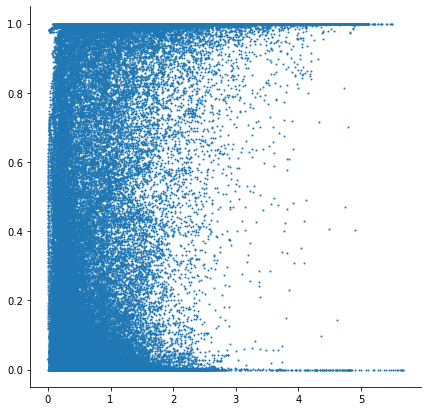

In [14]:
plt.figure(figsize=(7, 7))
plt.scatter(data['multiunit_firing_rate'] / data['multiunit_firing_rate'].mean(), detector_results.replay_probability, s=1)
sns.despine()

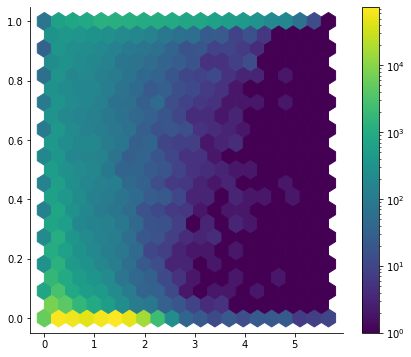

In [15]:
plt.figure(figsize=(7, 6))
plt.hexbin(data['multiunit_firing_rate'].squeeze() / data['multiunit_firing_rate'].values.mean(),
           detector_results.replay_probability.squeeze(),
           gridsize=20, bins='log')
plt.colorbar()
sns.despine()

KeyError: 'consensus_ripple_trace'

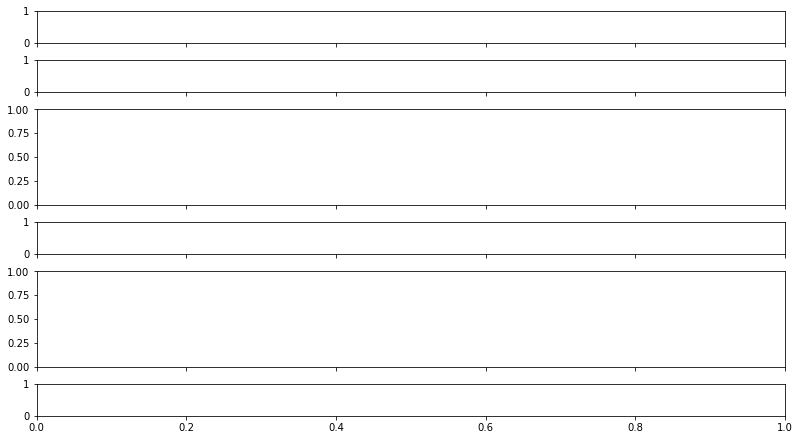

In [16]:
time_ind = slice(200_000, 210_000)

plot_detector(time_ind, data, replay_detector, detector_results)

In [ ]:
time_inds = np.stack((np.arange(0, detector_results.time.shape[0], 10_000),
                      np.append(np.arange(10_000, detector_results.time.shape[0], 10_000), detector_results.time.shape[0]-1)
                     ), axis=1)
for ind, (start, end) in enumerate(time_inds):
    time_ind = slice(start, end)
    print(time_ind)
    plot_detector(time_ind, data, replay_detector, detector_results)
    plt.suptitle(f"time: {detector_results.time.values[start]:0.3f} s - {detector_results.time.values[end]:0.3f} s")
    fig_name = f"time_chunks/time_chunk_{ind:02d}"
    plt.savefig(fig_name, bbox_inches='tight')
    plt.close(plt.gcf())

In [ ]:
from scipy.ndimage.measurements import label
import pandas as pd

def start_time(s):
    return s.index[0]


def end_time(s):
    return s.index[-1]


def max_probability(df):
    return df.max()


def duration(df):
    return (df.index[-1] - df.index[0])


def get_replay_times(results, probability_threshold=0.8,
                     minimum_duration=0.000):

    replay_labels = label(
        results.replay_probability > probability_threshold)[0]
    labels = pd.DataFrame(
        {'replay_number': replay_labels,
         'replay_probability': results.replay_probability.values},
        index=results.time.to_index())

    grouper = labels.loc[labels.replay_number > 0].groupby('replay_number')
    replay_times = (grouper
                    .agg([start_time, end_time, duration, max_probability]))
    replay_times.columns = replay_times.columns.get_level_values(1)

    replay_times = replay_times.loc[replay_times.duration > minimum_duration]
    labels[~labels.isin(replay_times.index.values)] = 0

    return replay_times, labels


In [ ]:
replay_info, is_replay = get_replay_times(detector_results)
replay_info

In [ ]:
time_index = np.arange(detector_results.time.size)

for replay_number in replay_info.index:
    start_ind, end_ind = time_index[(is_replay == replay_number).replay_number][[0, -1]]
    start_ind -= 125
    end_ind += 125
    start_ind = max(0, start_ind)
    time_ind = slice(start_ind, end_ind)
    print(replay_number)
    figsize = (20 * (end_ind - start_ind) / 1000, 7.5)
    plot_detector(time_ind, data, replay_detector, detector_results, figsize=figsize)
    plt.suptitle(f"Replay Number: {replay_number}")
    fig_name = f"replays/replay_number_{replay_number:03d}"
    plt.savefig(fig_name, bbox_inches='tight')
    plt.close(plt.gcf())

In [ ]:
avg_multiunit_rate = []
for replay_number in replay_info.index:
    start_ind, end_ind = time_index[(is_replay == replay_number).replay_number][[0, -1]]
    time_ind = slice(start_ind, end_ind)
    avg_multiunit_rate.append(data['multiunit_firing_rate'].iloc[time_ind].mean())
    
avg_multiunit_rate = np.asarray(avg_multiunit_rate)
plt.hist(avg_multiunit_rate / data['multiunit_firing_rate'].values.mean(), bins=25, density=True);
plt.axvline(1, color='black')
plt.axvline(np.median(avg_multiunit_rate / data['multiunit_firing_rate'].values.mean()), color='red')
plt.xscale('log')

In [ ]:
avg_ripple = []
for replay_number in replay_info.itertuples():
    avg_ripple.append(data['ripple_consensus_trace'].set_index(data['ripple_consensus_trace'].index / np.timedelta64(1, 's')).loc[replay_number.start_time:replay_number.end_time].mean())
    
avg_ripple = np.asarray(avg_ripple)
plt.hist(avg_ripple / data['ripple_consensus_trace'].values.mean(), bins=25, density=True);
plt.axvline(1, color='black')
plt.axvline(np.median(avg_ripple / data['ripple_consensus_trace'].values.mean()), color='red')
plt.xscale('log')

In [ ]:
from loren_frank_data_processing import make_actual_vs_linearized_position_movie

# make_actual_vs_linearized_position_movie(
#     data['track_graph'],
#     (data['position_info']
#      .assign(x_position=data['position_info'].nose_x, y_position=data['position_info'].nose_y)
#      .iloc[0:data['position_info'].index.shape[0] + 15:15]
#     ))

In [17]:
client.close()